# Stress Detection

In [112]:
import pandas as pd
import numpy as np
data = pd.read_csv("stress.csv")
print(data.head())

          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text     id  label  \
0  He said he had not felt that way before, sugge...  33181      1   
1  Hey there r/assistance, Not sure if this is th...   2606      0   
2  My mom then hit me with the newspaper and it s...  38816      1   
3  until i met my new boyfriend, he is amazing, h...    239      1   
4  October is Domestic Violence Awareness Month a...   1421      1   

   confidence  social_timestamp  social_karma  syntax_ari  ...  \
0         0.8        1521614353             5    1.806818  ...   
1         1.0        1527009817             4    9.429737  ...   
2         0.8        1535935605             2    7.769821  ...   
3         0.6        1516429555       

In [113]:
print(data.isnull().sum())

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64


So this dataset does not have any null values. Now let’s prepare the text column of this dataset to clean the text column with stopwords, links, special symbols and language errors:

In [114]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from urllib.parse import urlparse

nltk.download('stopwords')
nltk.download('wordnet')
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean(text):
    try:
        # Convert text to lowercase
        text = str(text).lower()
        # Remove brackets
        text = re.sub('[][)(]',' ', text)
        # Remove URLs
        text = [word for word in text.split() if not urlparse(word).scheme]
        text = ' '.join(text)
        # Remove escape characters
        text = re.sub(r'\@\w+','', text)
        # Remove HTML tags 
        text = re.sub(re.compile("<.*?>"), '', text)
        # Remove non-alphanumeric characters
        text = re.sub("[^A-Za-z0-9]", ' ', text)
        # Tokenize text
        tokens = word_tokenize(text)
        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatize tokens
        tokens = [ps.stem(word) for word in tokens]

        # Join tokens back into text
        text = ' '.join(tokens)

        return text
    except Exception as ex:
        print(sent,"\n")
        print("Error ",ex)

data["text"] = data["text"].apply(clean)


[nltk_data] Downloading package stopwords to C:\Users\Dipen
[nltk_data]     Patel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Dipen
[nltk_data]     Patel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Word cloud showing most used words in the dataset:

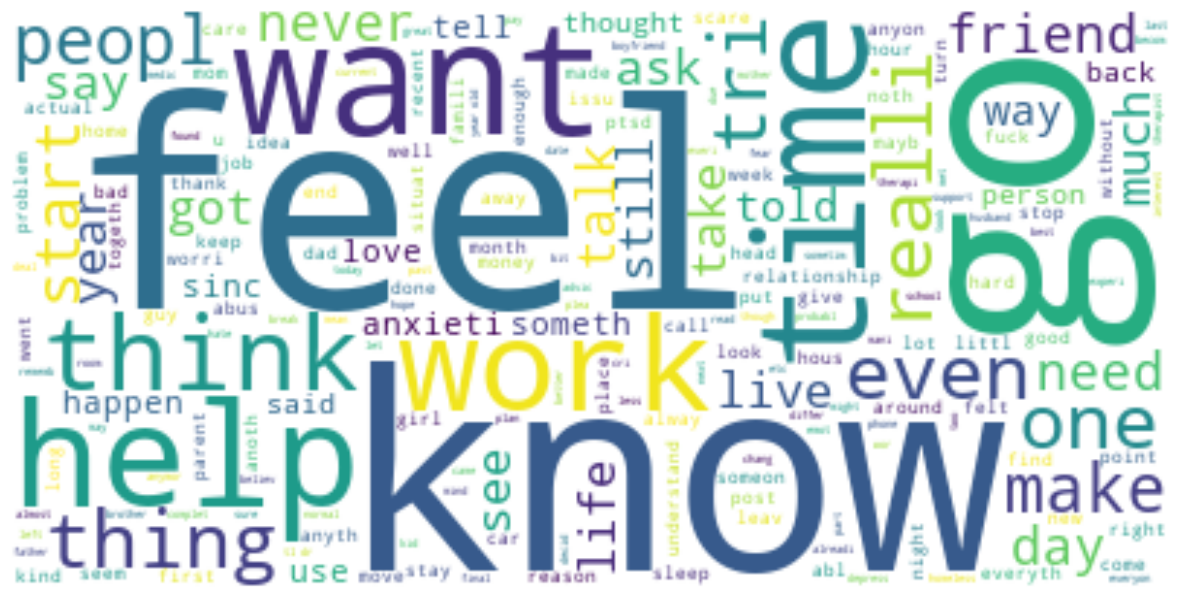

In [115]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Stress Detection Model
The label column in this dataset contains labels as 0 and 1. 0 means no stress, and 1 means stress. I will use Stress and No stress labels instead of 1 and 0. So let’s prepare this column accordingly and select the text and label columns for the process of training a machine learning model:

In [116]:
data["label"] = data["label"].map({0: "No Stress", 1: "Stress"})
data = data[["text", "label"]]
print(data.head())

                                                text      label
0  said felt way sugget go rest trigger ahead you...     Stress
1  hey r assist sure right place post goe current...  No Stress
2  mom hit newspap shock would know like play hit...     Stress
3  met new boyfriend amaz kind sweet good student...     Stress
4  octob domest violenc awar month domest violenc...     Stress


Word cloud for words in no stress:

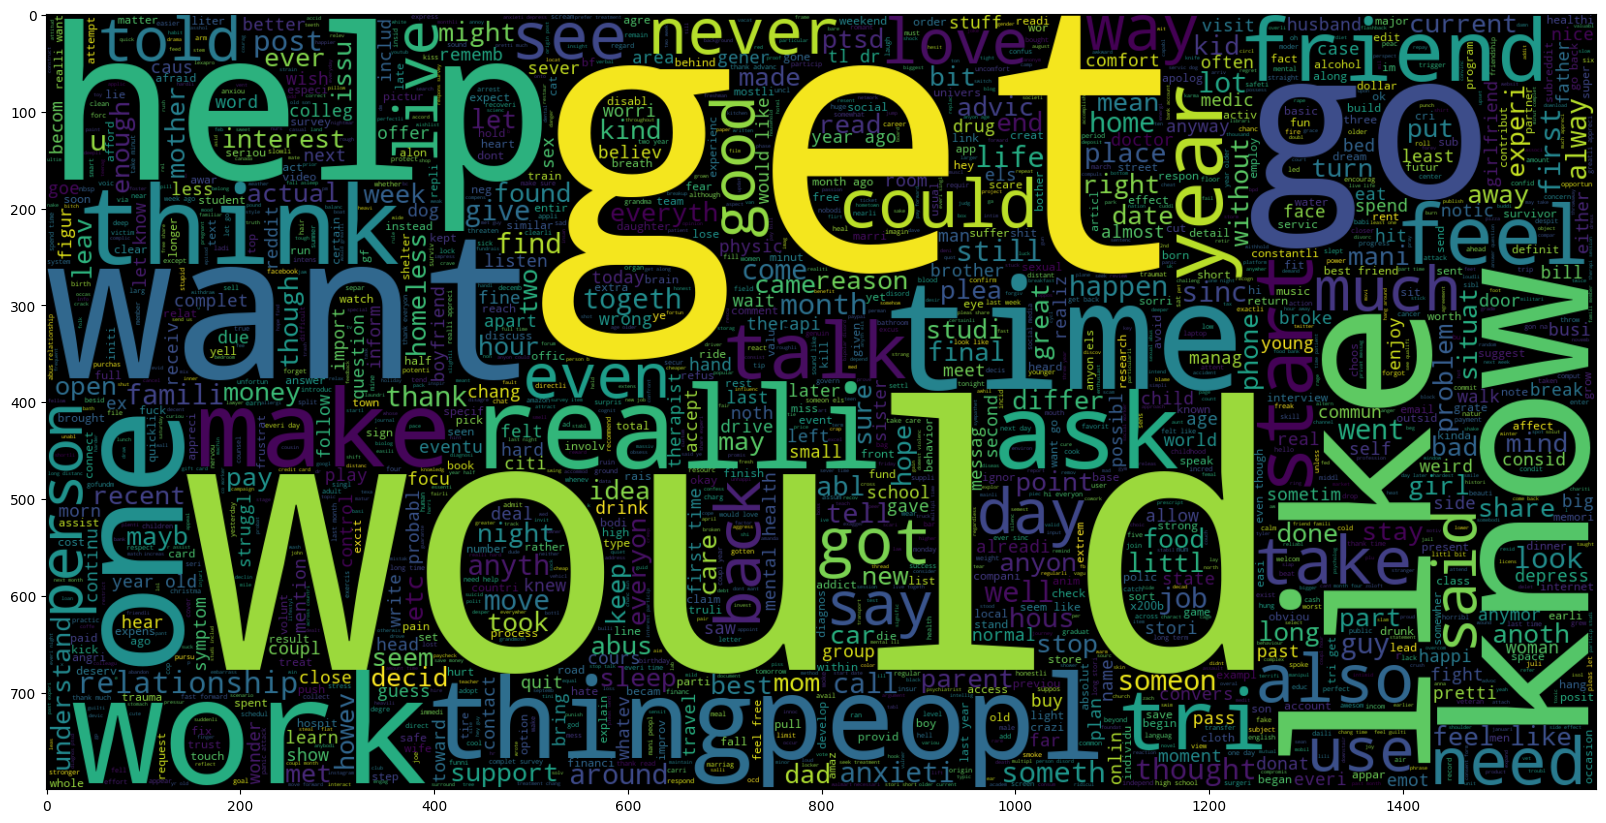

In [117]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(data[data.label == "No Stress"].text))
plt.imshow(wc, interpolation = 'bilinear')

wordcloud for stress:

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(data[data.label == "Stress"].text))
plt.imshow(wc, interpolation = 'bilinear')

In [118]:
from sklearn.model_selection import train_test_split

Now I will split this dataset into training and test sets:

In [119]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

x = np.array(data["text"])
y = np.array(data["label"])

from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(min_df=1)
tf_df = tf.fit_transform(x)
tf_df.toarray()


xtrain, xtest, ytrain, ytest = train_test_split(tf_df, y,
                                                test_size=0.2,
                                                random_state=42)

Trying different classifers to see their accuracies:

In [120]:
from sklearn.metrics import accuracy_score


In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Different kernels to try
    'gamma': [0.1, 0.5, 0.9],  # Kernel coefficient
    'C': [0.1, 0.5, 0.7, 1.0]  # Regularization parameter
}

# Initialize the SVC classifier
svm = SVC(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(xtrain, ytrain)

# Get the best parameters and the best score
svm_best_params = grid_search.best_params_
svm_best_score = grid_search.best_score_

print("Best parameters:", svm_best_params)
print("Best cross-validation score:", svm_best_score)

# Get the best model
svm_best_model = grid_search.best_estimator_

# Evaluate the best model on training and test sets
svm_train_score = svm_best_model.score(xtrain, ytrain)
svm_test_score = svm_best_model.score(xtest, ytest)

print("Train set accuracy with best parameters:", svm_train_score)
print("Test set accuracy with best parameters:", svm_test_score)


Best parameters: {'C': 0.5, 'gamma': 0.1, 'kernel': 'linear'}
Best cross-validation score: 0.7422907488986784
Train set accuracy with best parameters: 0.8964757709251101
Test set accuracy with best parameters: 0.727112676056338


In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {
    'C': [0.1, 0.5, 1.0],  # Regularization parameter
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Optimization algorithm
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Initialize the logistic regression classifier
logistic_reg = LogisticRegression(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(logistic_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(xtrain, ytrain)

# Get the best parameters and the best score
log_best_params = grid_search.best_params_
log_best_score = grid_search.best_score_

print("Best parameters:", log_best_params)
print("Best cross-validation score:", log_best_score)

# Get the best model
log_best_model = grid_search.best_estimator_

# Evaluate the best model on training and test sets
log_train_score = log_best_model.score(xtrain, ytrain)
log_test_score =log_best_model.score(xtest, ytest)

print("Train set accuracy with best parameters:", log_train_score)
print("Test set accuracy with best parameters:", log_test_score)


Best parameters: {'C': 1.0, 'max_iter': 100, 'solver': 'saga'}
Best cross-validation score: 0.7387665198237885
Train set accuracy with best parameters: 0.9013215859030838
Test set accuracy with best parameters: 0.7376760563380281


In [123]:
from sklearn.naive_bayes import BernoulliNB

# Define a list of alpha values to try
alpha_values = [0.01,0.1, 0.5, 1.0, 2.0]

# Initialize a list to store results
results = []

# Iterate over alpha values
for alpha in alpha_values:
    # Initialize Bernoulli Naive Bayes classifier with current alpha value
    bernoulli_nb = BernoulliNB(alpha=alpha)
    
    # Train the classifier
    bernoulli_nb.fit(xtrain, ytrain)
    
    # Evaluate the classifier on test set
    test_accuracy = bernoulli_nb.score(xtest, ytest)
    
    # Store the result
    results.append((alpha, test_accuracy))
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
alpha, BNB_test_accuracy = sorted_results[0]
print("Top result - Alpha:", alpha, "Test set accuracy:", BNB_test_accuracy)

# Print the results
for alpha, accuracy in results:
    print("Alpha:", alpha, "Test set accuracy:", accuracy)


Top result - Alpha: 1.0 Test set accuracy: 0.7552816901408451
Alpha: 0.01 Test set accuracy: 0.7376760563380281
Alpha: 0.1 Test set accuracy: 0.7429577464788732
Alpha: 0.5 Test set accuracy: 0.7535211267605634
Alpha: 1.0 Test set accuracy: 0.7552816901408451
Alpha: 2.0 Test set accuracy: 0.7376760563380281


In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(xtrain, ytrain)

# Get the best parameters and the best score
RFC_best_params = grid_search.best_params_
RFC_best_score = grid_search.best_score_

print("Best parameters:", RFC_best_params)
print("Best cross-validation score:", RFC_best_score)

# Get the best model
RFC_best_model = grid_search.best_estimator_

# Evaluate the best model on training and test sets
RFC_train_score = RFC_best_model.score(xtrain, ytrain)
RFC_test_score = RFC_best_model.score(xtest, ytest)

print("Train set accuracy with best parameters:", RFC_train_score)
print("Test set accuracy with best parameters:", RFC_test_score)


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.7180616740088106
Train set accuracy with best parameters: 0.9986784140969163
Test set accuracy with best parameters: 0.727112676056338


In [125]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # Smoothing parameter
}

# Initialize the Multinomial Naive Bayes classifier
multinomial_nb = MultinomialNB()

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(multinomial_nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(xtrain, ytrain)

# Get the best parameters and the best score
MNB_best_params = grid_search.best_params_
MNB_best_score = grid_search.best_score_

print("Best parameters:", MNB_best_params)
print("Best cross-validation score:", MNB_best_score)

# Get the best model
MNB_best_model = grid_search.best_estimator_

# Evaluate the best model on training and test sets
MNB_train_score = MNB_best_model.score(xtrain, ytrain)
MNB_test_score = MNB_best_model.score(xtest, ytest)

print("Train set accuracy with best parameters:", MNB_train_score)
print("Test set accuracy with best parameters:", MNB_test_score)


Best parameters: {'alpha': 0.1}
Best cross-validation score: 0.7202643171806168
Train set accuracy with best parameters: 0.9475770925110132
Test set accuracy with best parameters: 0.7359154929577465


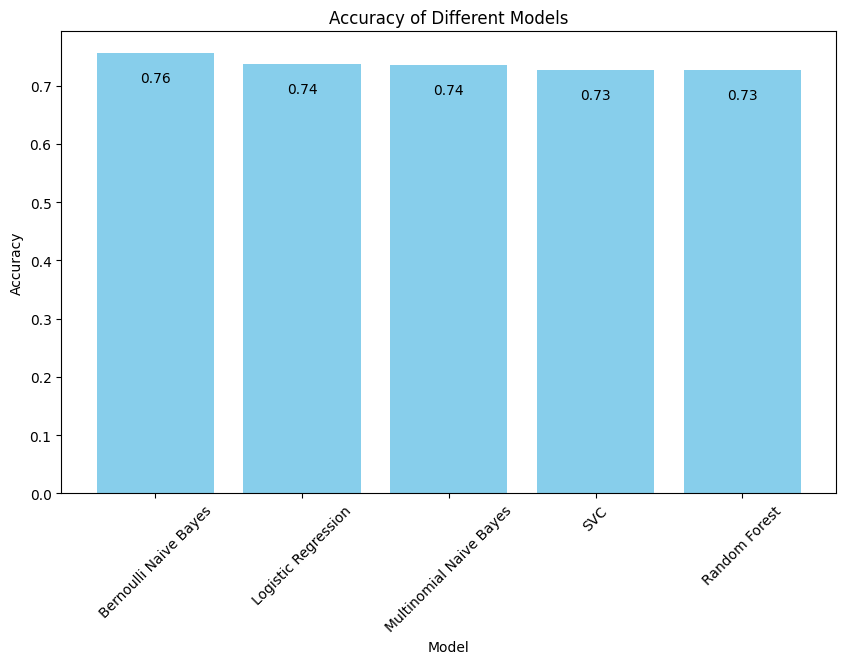

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Results of all models with their accuracies
results = {
    'SVC': svm_test_score,
    'Logistic Regression': log_test_score,
    'Bernoulli Naive Bayes': BNB_test_accuracy,
    'Random Forest': RFC_test_score,
    'Multinomial Naive Bayes': MNB_test_score
}

# Sort models based on accuracy in descending order
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

# Plotting bar chart
models = [x[0] for x in sorted_results]
accuracies = [x[1] for x in sorted_results]

plt.figure(figsize=(10, 6))
bars=plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{accuracy:.2f}', ha='center', color='black')

plt.show()



Making a voting Classifier

In [127]:

estimators=[
        ("BNB", BernoulliNB(alpha=1)),
        ("Logistics Regression", log_best_model),
        ("SVM", svm_best_model),
        ("Random Forest", RFC_best_model),
        ("MultinomialNB", MNB_best_model)]

# Use voting classifier with top three models
voting_clf = VotingClassifier(estimators, voting='hard')
voting_clf.fit(xtrain, ytrain)

# Predict using voting classifier
voting_pred = voting_clf.predict(xtest)

# Evaluate accuracy of voting classifier
voting_accuracy = accuracy_score(ytest, voting_pred)
print("Accuracy of Voting Classifier :", voting_accuracy)


Accuracy of Voting Classifier : 0.7676056338028169


Now let’s test the performance of our model on some random sentences based on mental health:

In [128]:
def preprocess_input(text):
    # Apply the same preprocessing steps as used for the training data
    processed_text = clean(text)  # Use your clean function here
    # Vectorize the preprocessed input
    vectorized_input = tf.transform([processed_text])
    return vectorized_input

def predict_class(input_text):
    # Preprocess the input
    preprocessed_input = preprocess_input(input_text)
    
    # Predict the class
    predicted_class = voting_clf.predict(preprocessed_input)
    
    return predicted_class[0]  # Assuming you only want to return the predicted class label



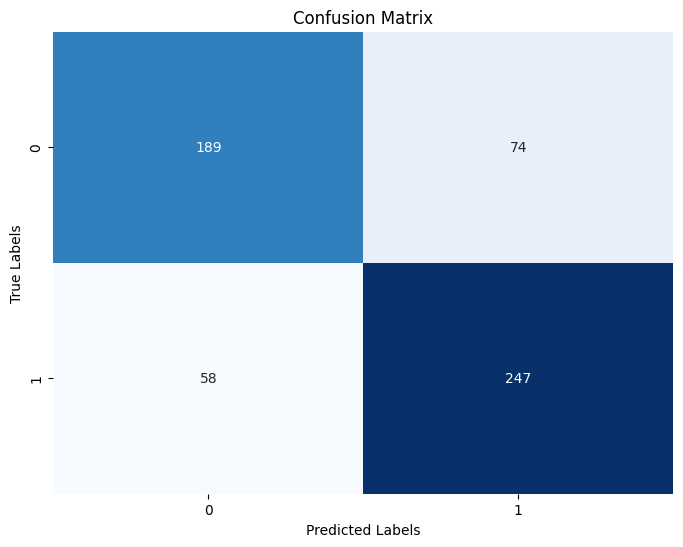

In [129]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels = ytest
predicted_labels = voting_pred  

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [130]:
# Example usage:
user_input = "This is too much work I want to just leave"
predicted_class = predict_class(user_input)
print("Predicted class:", predicted_class)

Predicted class: Stress
